In [1]:
import json


# para DCIS-1, IBC-1
modelo_reglas = {
  "start_node": "START_POINT",
  "nodes": {
    "START_POINT": {
      "type": "branch",
      "description": "Punto de entrada inicial del clasificador de Cáncer de Mama.",
      "reference_page": "Index",
      "branches": [
        {
          "condition_label": "DCIS",
          "condition": { "property": "diagnostico_actual.tipo_histologico", "operator": "equals", "value": { "label": "DCIS", "snomed_id": "187515008", "cui": "C0007102" } },
          "next_node": "DCIS-1_WORKUP"
        },
        {
          "condition_label": "Invasivo",
          "condition": { "property": "diagnostico_actual.tipo_histologico", "operator": "equals", "value": { "label": "Invasivo", "snomed_id": "126928004", "cui": "C0677948" } },
          "next_node": "BINV-1_H_P_LABS"
        },
        {
          "condition_label": "IBC",
          "condition": { "property": "diagnostico_actual.tipo_histologico", "operator": "equals", "value": { "label": "IBC", "snomed_id": "254845008", "cui": "C0279632" } },
          "next_node": "IBC-1_WORKUP"
        }
      ]
    },

    # DCIS
    "DCIS-1_WORKUP": {
      "type": "action",
      "description": "WORKUP (DCIS): H&P, Mamografía Diag. Bilateral, Patología (Revisión, ER status).",
      "reference_page": "DCIS-1",
      "snomed_concept_id": "439241000124101",
      "next_node": "DCIS-1_DECISION_CIRUGIA"
    },
    "DCIS-1_DECISION_CIRUGIA": {
      "type": "branch",
      "description": "Decisión de Tratamiento Primario (DCIS)",
      "reference_page": "DCIS-1",
      "branches": [
        {
          "condition_label": "Cirugía Conservadora (BCS)",
          "condition": { "property": "diagnostico_actual.cirugia_realizada[0].tipo", "operator": "equals", "value": "BCS" },
          "next_node": "DCIS-1_POST_BCS_RT_OPTIONS"
        },
        {
          "condition_label": "Mastectomía Total",
          "condition": { "property": "diagnostico_actual.cirugia_realizada[0].tipo", "operator": "equals", "value": "Mastectomia" },
          "next_node": "DCIS-2_SEGUIMIENTO"
        }
      ]
    },
    "DCIS-1_POST_BCS_RT_OPTIONS": {
      "type": "branch",
      "description": "Opciones de RT post-BCS para DCIS",
      "reference_page": "DCIS-1",
      "branches": [
        {
          "condition_label": "WBRT (Estándar)",
          "condition": { "property": "diagnostico_actual.rt_planificada", "operator": "equals", "value": "WBRT" },
          "next_node": "DCIS-2_SEGUIMIENTO"
        },
        {
          "condition_label": "No RT (Bajo Riesgo)",
          "condition": { "property": "diagnostico_actual.rt_planificada", "operator": "equals", "value": "No_RT" },
          "next_node": "DCIS-2_SEGUIMIENTO"
        }
      ]
    },
    "DCIS-2_SEGUIMIENTO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: Terapia Endocrina (si ER+) y Seguimiento.",
      "reference_page": "DCIS-2",
      "recommendation_code": "DCIS-2.END",
      "next_node": "FIN_DE_RUTA_CURATIVA"
    },

    # --- RUTA IBC (AHORA DEFINIDA) ---
    "IBC-1_WORKUP": {
      "type": "action",
      "description": "WORKUP (IBC): H&P, Fotografía Médica, Labs, Patología (ER/PR/HER2), Estudios de Extensión Completos (TC, Gammagrafía ósea o PET/CT).",
      "reference_page": "IBC-1",
      "snomed_concept_id": "443312003",
      "next_node": "IBC-1_TRATAMIENTO_PREOP"
    },
    "IBC-1_TRATAMIENTO_PREOP": {
      "type": "action",
      "description": "TRATAMIENTO: Terapia Sistémica Preoperatoria (Quimio + Terapia Dirigida si HER2+).",
      "reference_page": "IBC-1",
      "snomed_concept_id": "387612001",
      "next_node": "IBC-2_EVAL_RESPUESTA"
    },
    "IBC-2_EVAL_RESPUESTA": {
        "type": "recommendation",
        "description": "RECOMENDACIÓN: Mastectomía + ALND + PMRT + RNI. (Ruta IBC completa en IBC-2).",
        "reference_page": "IBC-2",
        "recommendation_code": "IBC-2.ALL",
        "next_node": "FIN_DE_RUTA_CURATIVA"
    },

    # --- RUTA INVASIVA (BINV) ---
    "BINV-1_H_P_LABS": {
      "type": "action",
      "description": "WORKUP (Invasivo): H&P, Labs, Fertilidad, Prueba Embarazo",
      "reference_page": "BINV-1",
      "snomed_concept_id": "422485002",
      "cui": "C1546788",
      "next_node": "BINV-1_IMAGING"
    },
    "BINV-1_IMAGING": {
      "type": "action",
      "description": "WORKUP (Invasivo): Mamografía Diag. Bilateral y Ultrasonido",
      "reference_page": "BINV-1",
      "snomed_concept_id": "312251004",
      "cui": "C0817342",
      "next_node": "BINV-1_PATHOLOGY"
    },
    "BINV-1_PATHOLOGY": {
      "type": "action",
      "description": "WORKUP (Invasivo): Patología (Biopsia) -> Determinar ER, PR, HER2",
      "estate": "IN_PROGRESS",
      "reference_page": "BINV-1",
      "snomed_concept_id": "252416005",
      "cui": "C0184497",
      "next_node": "BINV-1_CLASIFICACION_ESTADIO"
    },
    "BINV-1_CLASIFICACION_ESTADIO": {
      "type": "branch",
      "description": "CLASIFICACIÓN ESTADIO CLÍNICO (cTNM)",
      "reference_page": "BINV-1",
      "branches": [
        {
          "condition_label": "cT0, cN+, M0 (Oculto)",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "diagnostico_actual.estadio_T_clinico", "operator": "equals", "value": "cT0" },
              { "property": "diagnostico_actual.estadio_N_clinico", "operator": "in", "value": ["cN1", "cN2", "cN3"] },
              { "property": "diagnostico_actual.estadio_M_clinico", "operator": "equals", "value": "cM0" }
            ]
          },
          "next_node": "RECOMENDACION_GUIAS_OCULTO"
        },
        {
          "condition_label": "Metastásico (M1) o Recurrente",
          "condition": {
            "operator": "OR",
            "clauses": [
              { "property": "diagnostico_actual.estadio_M_clinico", "operator": "equals", "value": { "label": "cM1", "snomed_id": "424132000", "cui": "C1705977" } },
              { "property": "diagnostico_actual.recurrente", "operator": "equals", "value": True }
            ]
          },
          "next_node": "BINV-18_WORKUP_H_P_LABS"
        },
        {
          "condition_label": "Localizado (cT1-4, cN0-3, M0)",
          "condition": { "property": "diagnostico_actual.estadio_M_clinico", "operator": "equals", "value": { "label": "cM0", "snomed_id": "423697009", "cui": "C1705976" } },
          "next_node": "BINV-1_DECISION_PREOPERATORIA"
        }
      ]
    },
    "BINV-1_DECISION_PREOPERATORIA": {
      "type": "branch",
      "description": "¿Considerar Terapia Sistémica Preoperatoria? (Ver BINV-L)",
      "reference_page": "BINV-1",
      "branches": [
        {
          "condition_label": "Sí, considera preop",
          "condition": { "property": "diagnostico_actual.considera_preop", "operator": "equals", "value": True },
          "next_node": "BINV-12_WORKUP_PREOP"
        },
        {
          "condition_label": "No, cirugía primero",
          "condition": { "property": "diagnostico_actual.considera_preop", "operator": "equals", "value": False },
          "next_node": "BINV-1_DECISION_CIRUGIA"
        }
      ]
    },
    "BINV-12_WORKUP_PREOP": {
      "type": "action",
      "description": "WORKUP PREOPERATORIO: Evaluación axilar (US + biopsia con clip), Labs, Estudios de extensión (TC, Gammagrafía ósea o PET/CT).",
      "reference_page": "BINV-12",
      "next_node": "BINV-13_MARCAJE_PREOP"
    },
    "BINV-13_MARCAJE_PREOP": {
        "type": "recommendation",
        "description": "RECOMENDACIÓN: Iniciar Terapia Sistémica Preoperatoria (lógica en BINV-13/14/15/16).",
        "reference_page": "BINV-13",
        "recommendation_code": "BINV-13.START_NEO",
        "next_node": "FIN_DE_RUTA_CURATIVA"
    },
    "BINV-1_DECISION_CIRUGIA": {
      "type": "branch",
      "description": "Elección de Cirugía (BCS vs Mastectomía)",
      "reference_page": "BINV-1",
      "branches": [
        {
          "condition_label": "Cirugía Conservadora (BCS)",
          "condition": { "property": "diagnostico_actual.cirugia_realizada[0].tipo", "operator": "equals", "value": { "label": "BCS", "snomed_id": "449710000", "cui": "C1547432" } },
          "next_node": "BINV-2_LOGIC_RT_POST_BCS"
        },
        {
          "condition_label": "Mastectomía",
          "condition": { "property": "diagnostico_actual.cirugia_realizada[0].tipo", "operator": "equals", "value": { "label": "Mastectomia", "snomed_id": "68962001", "cui": "C0024881" } },
          "next_node": "BINV-3_LOGIC_RT_POST_MAST"
        }
      ]
    },
    "BINV-2_LOGIC_RT_POST_BCS": {
      "type": "branch",
      "description": "Lógica de RT después de BCS (Estado Ganglionar Patológico)",
      "reference_page": "BINV-2",
      "next_node_common": "BINV-4_CLASIFICACION_SISTEMICA",
      "branches": [
        {
          "condition_label": "pN0 (Ganglios Negativos)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": { "label": "pN0", "snomed_id": "443393007", "cui": "C1963071" } },
          "next_node": "BINV-2_PN0_OPTIONS"
        },
        {
          "condition_label": "pN1a (1-3 Ganglios +) Y cumple Z0011",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": "pN1a" },
              { "property": "diagnostico_actual.cumple_Z0011", "operator": "equals", "value": True }
            ]
          },
          "next_node": "RECOMENDACION_BINV2_PN1A_Z0011"
        },
        {
          "condition_label": "pN1a (1-3 Ganglios +) Y NO cumple Z0011",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": "pN1a" },
              { "property": "diagnostico_actual.cumple_Z0011", "operator": "equals", "value": False }
            ]
          },
          "next_node": "RECOMENDACION_BINV2_PN1A_NO_Z0011"
        },
        {
          "condition_label": "pN2-3 (>=4 Ganglios +)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN2", "pN3"] },
          "next_node": "RECOMENDACION_BINV2_PN2_3"
        }
      ]
    },
    "BINV-2_PN0_OPTIONS": {
      "type": "branch",
      "description": "Opciones de RT para pN0 después de BCS",
      "reference_page": "BINV-2",
      "next_node_common": "BINV-4_CLASIFICACION_SISTEMICA",
      "branches": [
        {
          "condition_label": "Criterios Omisión RT (ej. >70, pT1...)",
          "condition": { "property": "diagnostico_actual.criterios_omision_RT", "operator": "equals", "value": True },
          "next_node": "RECOMENDACION_BINV2_PN0_OMITIR_RT"
        },
        {
          "condition_label": "Criterios APBI (Bajo Riesgo)",
          "condition": { "property": "diagnostico_actual.criterios_APBI", "operator": "equals", "value": True },
          "next_node": "RECOMENDACION_BINV2_PN0_APBI"
        },
        {
          "condition_label": "Default: WBRT",
          "condition": { "property": "default", "operator": "equals", "value": True },
          "next_node": "RECOMENDACION_BINV2_PN0_WBRT"
        }
      ]
    },
    "BINV-3_LOGIC_RT_POST_MAST": {
      "type": "branch",
      "description": "Lógica de PMRT después de Mastectomía (pT, pN, Márgenes)",
      "reference_page": "BINV-3",
      "next_node_common": "BINV-4_CLASIFICACION_SISTEMICA",
      "branches": [
        {
          "condition_label": "Ganglios Negativos, <=pT2, Márgenes >=1mm",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": { "label": "pN0", "snomed_id": "443393007", "cui": "C1963071" } },
              { "property": "diagnostico_actual.estadio_T_patologico", "operator": "in", "value": ["pT1", "pT2"] },
              { "property": "diagnostico_actual.cirugia_realizada[0].margenes_quirurgicos_mm", "operator": "greater_than_or_equal", "value": 1.0 }
            ]
          },
          "next_node": "RECOMENDACION_BINV3_NO_RT"
        },
        {
          "condition_label": "1-3 Ganglios Positivos (pN1)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": "pN1" },
          "next_node": "RECOMENDACION_BINV3_FUERTE_CONSIDERAR_PMRT_RNI"
        },
        {
          "condition_label": ">=4 Ganglios Positivos (pN2-3)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN2", "pN3"] },
          "next_node": "RECOMENDACION_BINV3_PMRT_RNI_CAT1"
        },
        {
          "condition_label": "Márgenes Positivos (<1mm)",
          "condition": { "property": "diagnostico_actual.cirugia_realizada[0].margenes_quirurgicos_mm", "operator": "less_than", "value": 1.0 },
          "next_node": "RECOMENDACION_BINV3_MARGEN_POSITIVO_O_CERCANO"
        }
      ]
    },
    "BINV-4_CLASIFICACION_SISTEMICA": {
      "type": "branch",
      "description": "Bifurcación para Terapia Sistémica Adyuvante (Subtipo)",
      "reference_page": "BINV-4",
      "branches": [
        {
          "condition_label": "HR+ / HER2+",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "371911009", "cui": "C1304910" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "433511000124102", "cui": "C1512534" } }
            ]
          },
          "next_node": "BINV-5_LOGIC_NODAL"
        },
        {
          "condition_label": "HR+ / HER2- / Postmenopáusica",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "371911009", "cui": "C1304910" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "443834002", "cui": "C1705822" } },
              { "property": "antecedentes.estado_menopausico", "operator": "equals", "value": { "label": "Post", "snomed_id": "255385003", "cui": "C0025320" } }
            ]
          },
          "next_node": "BINV-6_LOGIC_NODAL"
        },
        {
          "condition_label": "HR+ / HER2- / Premenopáusica / pN0",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "371911009", "cui": "C1304910" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "443834002", "cui": "C1705822" } },
              { "property": "antecedentes.estado_menopausico", "operator": "equals", "value": { "label": "Pre", "snomed_id": "17631004", "cui": "C0033010" } },
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": { "label": "pN0", "snomed_id": "443393007", "cui": "C1963071" } }
            ]
          },
          "next_node": "BINV-7_LOGIC"
        },
        {
          "condition_label": "HR+ / HER2- / Premenopáusica / pN+",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "371911009", "cui": "C1304910" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "443834002", "cui": "C1705822" } },
              { "property": "antecedentes.estado_menopausico", "operator": "equals", "value": { "label": "Pre", "snomed_id": "17631004", "cui": "C0033010" } },
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN1", "pN1mi", "pN2", "pN3"] }
            ]
          },
          "next_node": "BINV-8_LOGIC_NODAL"
        },
        {
          "condition_label": "HR- / HER2+",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "371910000", "cui": "C1304911" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Positivo", "snomed_id": "433511000124102", "cui": "C1512534" } }
            ]
          },
          "next_node": "BINV-9_LOGIC"
        },
        {
          "condition_label": "HR- / HER2- (TNBC)",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "371910000", "cui": "C1304911" } },
              { "property": "get_HER2_status", "operator": "equals", "value": { "label": "Negativo", "snomed_id": "443834002", "cui": "C1705822" } }
            ]
          },
          "next_node": "BINV-10_LOGIC"
        },
        {
  "condition_label": "HR+ / HER2- / Premenopausal / pN+",
  "condition": {
    "operator": "AND",
    "clauses": [
      { "property": "get_HR_status", "operator": "equals", "value": "Positive" },
      { "property": "get_HER2_status", "operator": "equals", "value": "Negative" },
      { "property": "antecedentes.estado_menopausico", "operator": "equals", "value": "Pre" },
      { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN1", "pN1a", "pN1b", "pN1c", "pN1mi", "pN2", "pN3"] }
    ]
  },
  "next_node": "BINV-8_LOGIC_NODAL"
}
      ]
    },
    "BINV-5_LOGIC_NODAL": {
      "type": "branch",
      "description": "Lógica BINV-5: HR+/HER2+ (Estado Nodal)",
      "reference_page": "BINV-5",
      "branches": [
        {
          "condition_label": "pN0",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN0", "pN1mi"] },
          "next_node": "RECOMENDACION_BINV5_PN0"
        },
        {
          "condition_label": "pN+",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN1", "pN2", "pN3"] },
          "next_node": "RECOMENDACION_BINV5_PN_POS"
        }
      ]
    },
    "BINV-6_LOGIC_NODAL": {
      "type": "branch",
      "description": "Lógica BINV-6: HR+/HER2- Postmenopáusica (Estado Nodal)",
      "reference_page": "BINV-6",
      "branches": [
        {
          "condition_label": "pT1a (<=0.5 cm) y pN0",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "diagnostico_actual.estadio_T_patologico", "operator": "equals", "value": "pT1a" },
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "equals", "value": "pN0" }
            ]
          },
          "next_node": "RECOMENDACION_BINV6_T1A"
        },
        {
          "condition_label": "pT1b-T3 o pN1mi o pN1 (1-3 ganglios)",
          "condition": {
            "operator": "OR",
            "clauses": [
              { "property": "diagnostico_actual.estadio_T_patologico", "operator": "in", "value": ["pT1b", "pT1c", "pT2", "pT3"] },
              { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN1mi", "pN1"] }
            ]
          },
          "next_node": "BINV-6_CHECK_CHEMO_CANDIDACY"
        },
        {
          "condition_label": "pN2/pN3 (>=4 ganglios)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN2", "pN3"] },
          "next_node": "RECOMENDACION_BINV6_N2_N3"
        }
      ]
    },
    "BINV-6_CHECK_CHEMO_CANDIDACY": {
      "type": "branch",
      "description": "Lógica BINV-6: ¿Es candidata a quimioterapia?",
      "reference_page": "BINV-6",
      "branches": [
        {
          "condition_label": "No es candidata a quimio",
          "condition": { "property": "diagnostico_actual.candidata_quimio", "operator": "equals", "value": False },
          "next_node": "RECOMENDACION_BINV6_N1_NO_QUIMIO"
        },
        {
          "condition_label": "Sí es candidata a quimio",
          "condition": { "property": "diagnostico_actual.candidata_quimio", "operator": "equals", "value": True },
          "next_node": "BINV-6_CHECK_GENOMIC_ASSAY"
        }
      ]
    },
    "BINV-6_CHECK_GENOMIC_ASSAY": {
      "type": "branch",
      "description": "Lógica BINV-6: Revisar Ensayo 21-genes (Oncotype Dx) (Cat 1)",
      "reference_page": "BINV-6",
      "branches": [
        {
          "condition_label": "Score Recurrencia < 26",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.score", "operator": "less_than", "value": 26 },
          "next_node": "RECOMENDACION_BINV6_N1_RS_BAJO"
        },
        {
          "condition_label": "Score Recurrencia >= 26",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.score", "operator": "greater_than_or_equal", "value": 26 },
          "next_node": "RECOMENDACION_BINV6_N1_RS_ALTO"
        },
        {
          "condition_label": "No realizado (Not done)",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.realizado", "operator": "equals", "value": False },
          "next_node": "RECOMENDACION_BINV6_N1_RS_ALTO"
        }
      ]
    },
    "BINV-7_LOGIC": {
      "type": "branch",
      "description": "Lógica BINV-7: HR+/HER2- Premenopáusica pN0 (Estado pT)",
      "reference_page": "BINV-7",
      "branches": [
        {
          "condition_label": "pT1a (<=0.5 cm)",
          "condition": { "property": "diagnostico_actual.estadio_T_patologico", "operator": "equals", "value": "pT1a" },
          "next_node": "RECOMENDACION_BINV7_T1A"
        },
        {
          "condition_label": "pT1b-T3 (>0.5 cm)",
          "condition": { "property": "diagnostico_actual.estadio_T_patologico", "operator": "in", "value": ["pT1b", "pT1c", "pT2", "pT3"] },
          "next_node": "BINV-7_CHECK_CHEMO_CANDIDACY"
        }
      ]
    },
    "BINV-7_CHECK_CHEMO_CANDIDACY": {
      "type": "branch",
      "description": "Lógica BINV-7: ¿Es candidata a quimioterapia?",
      "reference_page": "BINV-7",
      "branches": [
        {
          "condition_label": "No es candidata a quimio",
          "condition": { "property": "diagnostico_actual.candidata_quimio", "operator": "equals", "value": False },
          "next_node": "RECOMENDACION_BINV7_N0_NO_QUIMIO"
        },
        {
          "condition_label": "Sí es candidata a quimio",
          "condition": { "property": "diagnostico_actual.candidata_quimio", "operator": "equals", "value": True },
          "next_node": "BINV-7_CHECK_GENOMIC_ASSAY"
        }
      ]
    },
    "BINV-7_CHECK_GENOMIC_ASSAY": {
      "type": "branch",
      "description": "Lógica BINV-7: Revisar Ensayo 21-genes (Oncotype Dx) (Cat 1)",
      "reference_page": "BINV-7",
      "branches": [
        {
          "condition_label": "Score Recurrencia <= 15",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.score", "operator": "less_than_or_equal", "value": 15 },
          "next_node": "RECOMENDACION_BINV7_N0_RS_15"
        },
        {
          "condition_label": "Score Recurrencia 16-25",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.score", "operator": "between", "value": [16, 25] },
          "next_node": "RECOMENDACION_BINV7_N0_RS_16_25"
        },
        {
          "condition_label": "Score Recurrencia >= 26",
          "condition": { "property": "diagnostico_actual.ensayo_genomico_21_genes.score", "operator": "greater_than_or_equal", "value": 26 },
          "next_node": "RECOMENDACION_BINV7_N0_RS_ALTO"
        }
      ]
    },
    "BINV-8_LOGIC_NODAL": {
      "type": "branch",
      "description": "Lógica BINV-8: HR+/HER2- Premenopáusica pN+ (Estado Nodal)",
      "reference_page": "BINV-8",
      "branches": [
        {
          "condition_label": "pN1mi o pN1 (1-3 ganglios)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN1mi", "pN1"] },
          "next_node": "RECOMENDACION_BINV8_N1"
        },
        {
          "condition_label": "pN2/pN3 (>=4 ganglios)",
          "condition": { "property": "diagnostico_actual.estadio_N_patologico", "operator": "in", "value": ["pN2", "pN3"] },
          "next_node": "RECOMENDACION_BINV8_N2_N3"
        }
      ]
    },
    "BINV-18_WORKUP_H_P_LABS": {
      "type": "action",
      "description": "WORKUP M1/RECURRENTE: H&P, Discutir objetivos de terapia, CBC, Panel metabólico.",
      "reference_page": "BINV-18",
      "next_node": "BINV-18_WORKUP_STAGING_IMAGING"
    },
    "BINV-18_WORKUP_STAGING_IMAGING": {
      "type": "action",
      "description": "WORKUP M1/RECURRENTE: TC Tórax/Abdomen/Pelvis con contraste, Gammagrafía ósea.",
      "reference_page": "BINV-18",
      "next_node": "BINV-18_WORKUP_BIOPSIA"
    },
    "BINV-18_WORKUP_BIOPSIA": {
      "type": "action",
      "description": "WORKUP M1/RECURRENTE: Biopsia de metástasis (REPETIR ER/PR/HER2).",
      "reference_page": "BINV-18",
      "snomed_concept_id": "1227092004",
      "cui": "C4329245",
      "next_node": "BINV-18_WORKUP_GENETICS"
    },
    "BINV-18_WORKUP_GENETICS": {
      "type": "action",
      "description": "WORKUP M1/RECURRENTE: Perfilamiento germinal (gBRCA) y somático (NGS).",
      "reference_page": "BINV-18",
      "snomed_concept_id": "1227091008",
      "cui": "C4329244",
      "next_node": "BINV-18_DECISION_TRATAMIENTO"
    },
    "BINV-18_DECISION_TRATAMIENTO": {
      "type": "branch",
      "description": "Decisión de tratamiento para M1/Recurrente",
      "reference_page": "BINV-18",
      "branches": [
        {
          "condition_label": "Recurrencia Local/Regional",
          "condition": { "property": "diagnostico_actual.es_recurrencia_local_regional", "operator": "equals", "value": True },
          "next_node": "BINV-19_LOGIC"
        },
        {
          "condition_label": "Irresecable o M1",
          "condition": { "property": "diagnostico_actual.es_recurrencia_irresecable_o_M1", "operator": "equals", "value": True },
          "next_node": "BINV-21_MANEJO_OSEO"
        }
      ]
    },
    "BINV-21_MANEJO_OSEO": {
      "type": "branch",
      "description": "M1: ¿Enfermedad ósea presente?",
      "reference_page": "BINV-21",
      "branches": [
        {
          "condition_label": "Sí, hay metástasis óseas",
          "condition": { "property": "diagnostico_actual.enfermedad_osea", "operator": "equals", "value": True },
          "next_node": "BINV-21_ADD_BONE_AGENT"
        },
        {
          "condition_label": "No hay metástasis óseas",
          "condition": { "property": "diagnostico_actual.enfermedad_osea", "operator": "equals", "value": False },
          "next_node": "BINV-21_BIFURCACION_BIOMARKER"
        }
      ]
    },
    "BINV-21_ADD_BONE_AGENT": {
      "type": "action",
      "description": "Añadir Denosumab, Ácido Zoledrónico o Pamidronato (Cat 1)",
      "reference_page": "BINV-21",
      "snomed_concept_id": "429721000124102",
      "cui": "C1540134",
      "next_node": "BINV-21_BIFURCACION_BIOMARKER"
    },
    "BINV-21_BIFURCACION_BIOMARKER": {
      "type": "branch",
      "description": "M1: Enrutador de Terapia Sistémica (Biomarcadores)",
      "reference_page": "BINV-21",
      "branches": [
        {
          "condition_label": "HR+ / HER2-",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": "Positivo" },
              { "property": "get_HER2_status", "operator": "equals", "value": "Negativo" }
            ]
          },
          "next_node": "BINV-22_LOGIC"
        },
        {
          "condition_label": "HR+ / HER2+",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": "Positivo" },
              { "property": "get_HER2_status", "operator": "equals", "value": "Positivo" }
            ]
          },
          "next_node": "BINV-24_LOGIC"
        },
        {
          "condition_label": "HR- / HER2+",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": "Negativo" },
              { "property": "get_HER2_status", "operator": "equals", "value": "Positivo" }
            ]
          },
          "next_node": "BINV-26_LOGIC"
        },
        {
          "condition_label": "HR- / HER2- (TNBC)",
          "condition": {
            "operator": "AND",
            "clauses": [
              { "property": "get_HR_status", "operator": "equals", "value": "Negativo" },
              { "property": "get_HER2_status", "operator": "equals", "value": "Negativo" }
            ]
          },
          "next_node": "BINV-27_LOGIC"
        }
      ]
    },


    "RECOMENDACION_GUIAS_OCULTO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: Referir a NCCN Guidelines for Occult Primary.",
      "reference_page": "BINV-1",
      "recommendation_code": "GUIAS_OCULTO"
    },
    "RECOMENDACION_BINV2_PN0_OMITIR_RT": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: Omitir RT (Cat 1) (si cumple criterios: ≥70, pT1, cN0, HR+)",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN0.OMIT_RT",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV2_PN0_APBI": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: APBI/PBI (Cat 1) (si cumple criterios de bajo riesgo)",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN0.APBI",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV2_PN0_WBRT": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: WBRT ± boost (Opción estándar)",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN0.WBRT",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV2_PN1A_Z0011": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: WBRT ± boost (Cat 1). RNI a discreción.",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN1.Z0011",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV2_PN1A_NO_Z0011": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: WBRT ± boost (Cat 1) + Considerar 'fuertemente' RNI integral.",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN1.NO_Z0011",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV2_PN2_3": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: WBRT ± boost (Cat 1) + RNI integral (Cat 1).",
      "reference_page": "BINV-2",
      "recommendation_code": "BINV-2_PN2_3",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV3_NO_RT": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: No RT.",
      "reference_page": "BINV-3",
      "recommendation_code": "BINV-3.NO_RT",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV3_FUERTE_CONSIDERAR_PMRT_RNI": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: Considerar 'fuertemente' PMRT a la pared torácica + RNI integral.",
      "reference_page": "BINV-3",
      "recommendation_code": "BINV-3.STRONG_CONSIDER_PMRT_RNI",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV3_PMRT_RNI_CAT1": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: PMRT a la pared torácica + RNI integral (Cat 1).",
      "reference_page": "BINV-3",
      "recommendation_code": "BINV-3.PMRT_RNI_CAT1",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV3_MARGEN_POSITIVO_O_CERCANO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN: Considerar PMRT (si <1mm) o Re-escisión (si margen positivo).",
      "reference_page": "BINV-3",
      "recommendation_code": "BINV-3.MARGIN_CLOSE_OR_POS",
      "next_node": "BINV-4_CLASIFICACION_SISTEMICA"
    },
    "RECOMENDACION_BINV5_PN0": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2+, pN0): Terapia basada en pT (TE, Quimio + Trastuzumab ± Pertuzumab).",
      "reference_page": "BINV-5",
      "recommendation_code": "BINV-5.PN0",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV5_PN_POS": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2+, pN+): Quimio + Trastuzumab + Pertuzumab (Cat 1, Preferido) + TE.",
      "reference_page": "BINV-5",
      "recommendation_code": "BINV-5.PN_POS",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV6_T1A": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Post, pT1aN0): Considerar Terapia Endocrina Adyuvante (Cat 2B).",
      "reference_page": "BINV-6",
      "recommendation_code": "BINV-6.T1A",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV6_N1_NO_QUIMIO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Post, pN1, No Quimio): Terapia Endocrina Adyuvante. Considerar Abemaciclib o Ribociclib.",
      "reference_page": "BINV-6",
      "recommendation_code": "BINV-6.N1.NO_CHEMO",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV6_N1_RS_BAJO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Post, pN1, RS < 26): Terapia Endocrina Adyuvante (Cat 1). Considerar Abemaciclib o Ribociclib.",
      "reference_page": "BINV-6",
      "recommendation_code": "BINV-6.N1.RS_LOW",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV6_N1_RS_ALTO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Post, pN1, RS >= 26): Quimioterapia Adyuvante seguida de Terapia Endocrina (Cat 1). Considerar Abemaciclib o Ribociclib.",
      "reference_page": "BINV-6",
      "recommendation_code": "BINV-6.N1.RS_HIGH",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV6_N2_N3": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Post, pN2/3): Quimioterapia Adyuvante + Terapia Endocrina (Cat 1). Considerar Abemaciclib/Ribociclib y/o Olaparib (si gBRCA1/2).",
      "reference_page": "BINV-6",
      "recommendation_code": "BINV-6.N2N3",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV7_T1A": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pT1aN0): Considerar Terapia Endocrina Adyuvante (Cat 2B).",
      "reference_page": "BINV-7",
      "recommendation_code": "BINV-7.T1A",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV7_N0_NO_QUIMIO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN0, No Quimio): Terapia Endocrina ± OFS. Considerar Ribociclib.",
      "reference_page": "BINV-7",
      "recommendation_code": "BINV-7.N0.NO_CHEMO",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV7_N0_RS_15": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN0, RS <= 15): Terapia Endocrina ± OFS. Considerar Ribociclib.",
      "reference_page": "BINV-7",
      "recommendation_code": "BINV-7.N0.RS_15",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV7_N0_RS_16_25": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN0, RS 16-25): Quimioterapia Adyuvante + TE ± OFS O TE + OFS. Considerar Ribociclib.",
      "reference_page": "BINV-7",
      "recommendation_code": "BINV-7.N0.RS_16_25",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV7_N0_RS_ALTO": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN0, RS >= 26): Quimioterapia Adyuvante + TE ± OFS. Considerar Ribociclib.",
      "reference_page": "BINV-7",
      "recommendation_code": "BINV-7.N0.RS_HIGH",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV8_N1": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN1): Quimioterapia Adyuvante + TE ± OFS. Considerar Abemaciclib o Ribociclib.",
      "reference_page": "BINV-8",
      "recommendation_code": "BINV-8.N1",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "RECOMENDACION_BINV8_N2_N3": {
      "type": "recommendation",
      "description": "RECOMENDACIÓN (HR+/HER2- Pre, pN2/3): Quimioterapia Adyuvante + TE ± OFS (Cat 1). Considerar Abemaciclib/Ribociclib y/o Olaparib (si gBRCA1/2).",
      "reference_page": "BINV-8",
      "recommendation_code": "BINV-8.N2N3",
      "next_node": "BINV-17_SEGUIMIENTO"
    },
    "BINV-17_SEGUIMIENTO": {
      "type": "action",
      "description": "VIGILANCIA/SEGUIMIENTO: H&P 1-4 veces/año x 5a, luego anual. Mamografía anual.",
      "reference_page": "BINV-17",
      "next_node": "FIN_DE_RUTA_CURATIVA"
    },
    "FIN_DE_RUTA_CURATIVA": {
      "type": "recommendation",
      "description": "Paciente en seguimiento de ruta curativa.",
      "recommendation_code": "END_CURATIVE"
    }
  }
}


nombre_archivo = "nccn_rules.json"


with open(nombre_archivo, 'w', encoding='utf-8') as f:

        json.dump(modelo_reglas, f, indent=4, ensure_ascii=False)



/tmp/ipython-input-1982992621.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


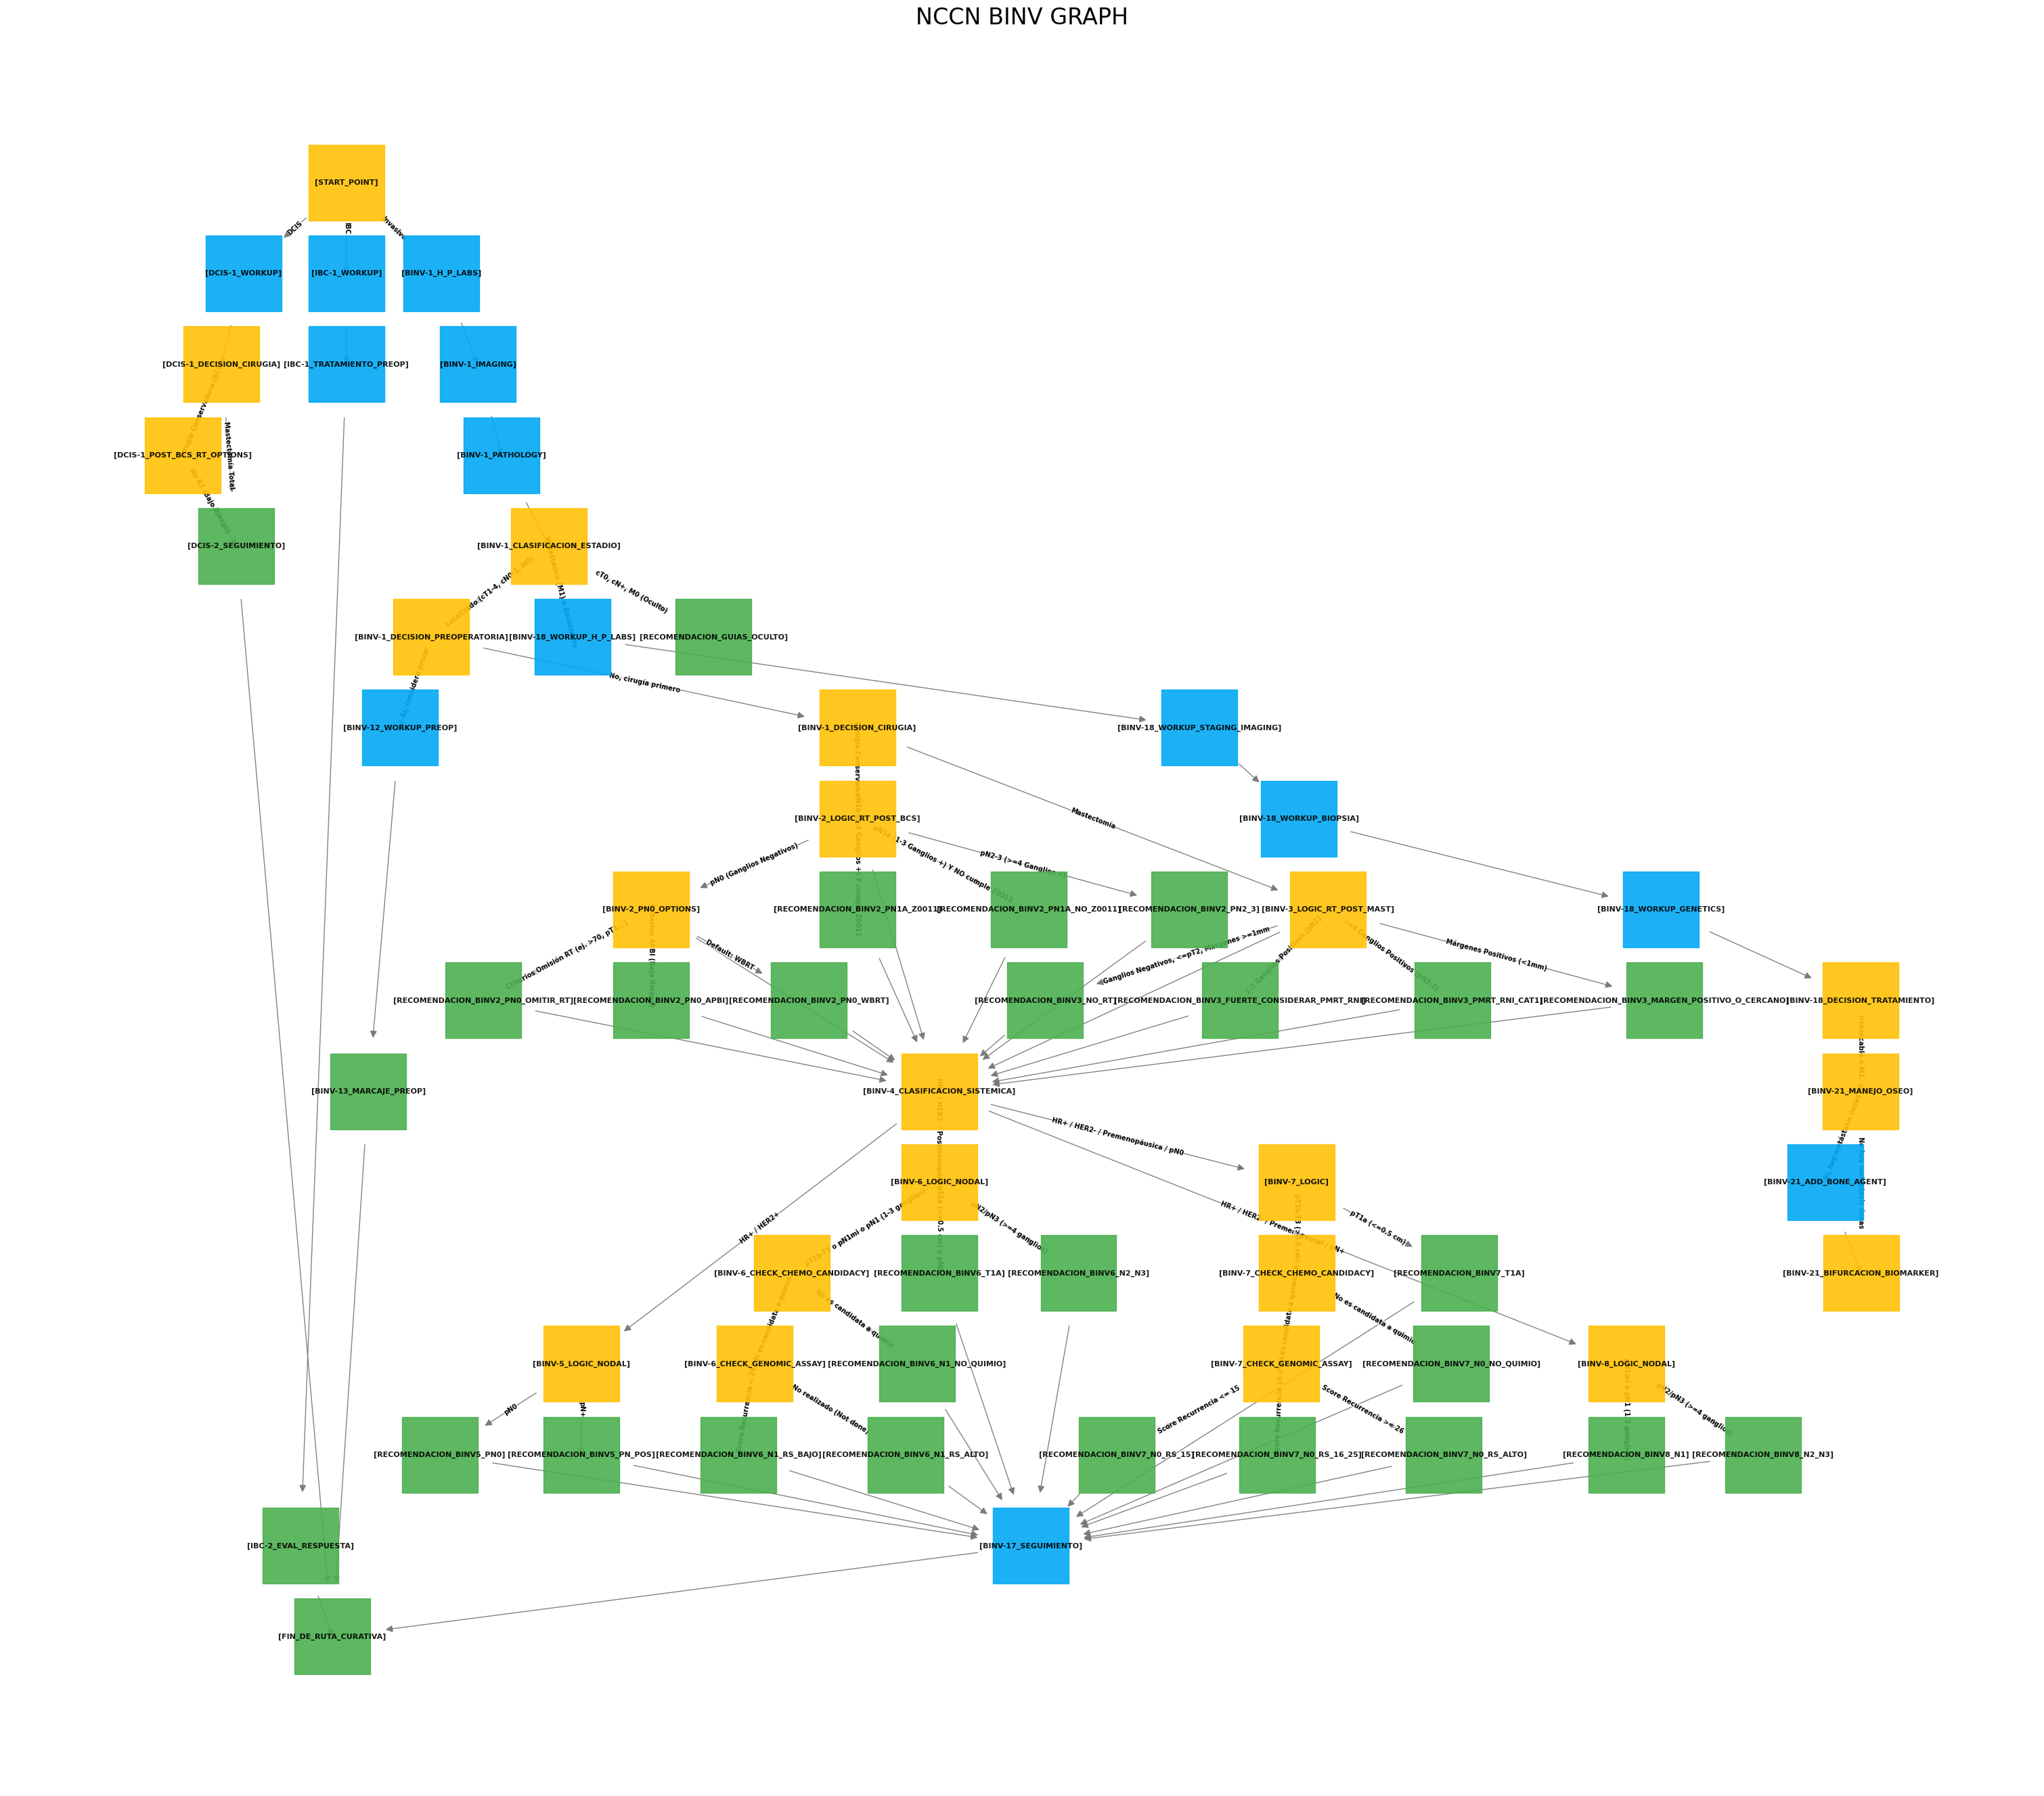

In [2]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import json



nombre_archivo = "nccn_rules_detallado.json"


with open(nombre_archivo, 'w', encoding='utf-8') as f:
        # json.dump() convertirá 'True' (Python) a 'true' (JSON)
        json.dump(modelo_reglas, f, indent=4, ensure_ascii=False)




def visualizar_grafo_detallado(json_path, output_image_file):

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            reglas = data.get('nodes', {})
            if not reglas:
                print(f"Advertencia: El archivo '{json_path}' está vacío.")
                return None
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{json_path}'.")
        print("Por favor, ejecuta primero el 'Script 1' para crear este archivo.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: El archivo '{json_path}' no es un JSON válido. Error: {e}")
        return None

    G = nx.DiGraph()

    color_map = {
        "branch": "#FFC107",        # amarillo  para decisiones
        "action": "#03A9F4",        # Azul para acciones/workup
        "recommendation": "#4CAF50" # verde para recomendaciones finales
    }


    for node_id, node_data in reglas.items():
        node_type = node_data.get('type', 'action')
        G.add_node(
            node_id,
            label= f"[{node_id}]", #  label=f"[{node_id}]\n{node_data.get('description', '')}",
            title=f"Ref: {node_data.get('reference_page', 'N/A')}\n{node_data.get('description', '')}",
            type=node_type,
            color=color_map.get(node_type, "#9E9E9E")
        )

    edge_labels = {}


    for node_id, node_data in reglas.items():
        node_type = node_data.get('type')


        next_node = node_data.get('next_node')
        if next_node and G.has_node(next_node):
            G.add_edge(node_id, next_node)


        for rama in node_data.get('branches', []):
            next_node_branch = rama.get('next_node')
            if next_node_branch and G.has_node(next_node_branch):
                G.add_edge(node_id, next_node_branch)

                edge_labels[(node_id, next_node_branch)] = rama.get('condition_label', '...')

        next_node_common = node_data.get('next_node_common')
        if next_node_common and G.has_node(next_node_common):
             G.add_edge(node_id, next_node_common, style='dashed')



    plt.figure(figsize=(30, 26))

    try:

        pos = graphviz_layout(G, prog="dot")
    except Exception as e:

        pos = nx.spring_layout(G, k=1.5, seed=42)

    labels = nx.get_node_attributes(G, 'label')
    colors = [G.nodes[n]['color'] for n in G.nodes()]

    nx.draw(
        G,
        pos,
        labels=labels,
        with_labels=True,
        node_color=colors,
        node_size=6500,
        node_shape="s",
        font_size=8,
        font_weight="bold",
        edge_color="#757575",
        arrowsize=15,
        alpha=0.9
    )

    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_color='black',
        font_size=7,
        font_weight='bold',
        bbox=dict(facecolor='white', alpha=0.6, pad=0.1, edgecolor='none')
    )

    plt.title("NCCN BINV GRAPH", size=24)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_image_file, dpi=200)

    plt.show()

visualizar_grafo_detallado('nccn_rules_detallado.json', 'grafo_nccn_detallado.png')